# Data

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## 01 data loading

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
x_path = os.path.join(base_path,os.getenv("Y_LABEL"))
y_path = os.path.join(base_path,os.getenv("Y_LABEL"))

In [4]:
x_df = pd.read_csv(x_path) 
y_df = pd.read_csv(y_path) 

In [5]:
y_df=y_df.drop(columns=["年份","季別"])
x_df=x_df.drop(columns=["年份","季別"])

In [6]:
y_df

,GDP
0,461774
1,488234
2,489504
3,498511
4,495361
...,...
167,6380686
168,6111775
169,6233160
170,6437479


In [7]:
x_df

,GDP
0,461774
1,488234
2,489504
3,498511
4,495361
...,...
167,6380686
168,6111775
169,6233160
170,6437479


## 02 data MinMaxScaler

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(x_df)
y_scaled = scaler_y.fit_transform(y_df)

In [8]:
X_seq,y_seq=[],[]


for i in range(4,len(X_scaled)):
    X_seq.append([X_scaled[i-1],X_scaled[i-2],X_scaled[i-3]])

for i in range(4,len(y_scaled)):
    y_seq.append([y_scaled[i]])

X_seq=np.array(X_seq)
y_seq=np.array(y_seq)


## 03 data spliting 80 & 20

In [9]:
train_size = int(len(X_seq) * 0.8)
lstm_X_train, lstm_X_test = X_seq[:train_size], X_seq[train_size:]
lstm_y_train, lstm_y_test = y_seq[:train_size], y_seq[train_size:]


# Model-LSTM

- train 1983 Q1 to 2015 Q3
- test  2015 Q4 to 2023 Q4

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

In [11]:
def evaluate_performance(y_true_scaled, y_pred_scaled, scaler, dataset_name=""):
    y_true = scaler.inverse_transform(y_true_scaled)
    y_pred = scaler.inverse_transform(y_pred_scaled)

    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)** 0.5
    mae = mean_absolute_error(y_true, y_pred)

    print(f"\n📊 {dataset_name} Performance:")
    print(f"  MSE:  {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")

In [12]:
def plot_gdp_forecast(year,name, test_actual, test_pred):
    plt.figure(figsize=(16, 7))

    # 畫出四條線
    plt.plot(year.iloc[138:],test_actual, label='Test Actual', color='green', linestyle='-')
    plt.plot(year.iloc[138:],test_pred, label='Test Predicted', color='orange', linestyle='--')

    # 標題與座標軸
    plt.title(f'GDP Forecast with {name}', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('GDP Value', fontsize=14)

    plt.xticks(year[138:],rotation=45)
    
    # 顯示圖例
    plt.legend()

    # 顯示網格
    plt.grid(True, linestyle='--', alpha=0.7)

    # 顯示圖片
    plt.show()

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

from itertools import product
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam



In [ ]:

param_grid = {
    "units": [64, 128, 256],
    "batch_size": [8, 16, 32],
    "optimizer": ["adam", "rmsprop", "nadam"],
    "dropout": [0.0, 0.2],
    "recurrent_dropout": [0.0, 0.2]
}


# 所有組合
keys = param_grid.keys()
combinations = list(product(*param_grid.values()))

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 紀錄最佳模型
best_score = float("inf")
best_params = None

for combo in combinations:
    params = dict(zip(keys, combo))
    print(f"Training with: {params}")

    # 選擇 optimizer
    if params["optimizer"] == "adam":
        optimizer = Adam()
    elif params["optimizer"] == "rmsprop":
        optimizer = RMSprop()
    else:
        optimizer = Nadam()

    # 建立模型
    model = Sequential()
    model.add(LSTM(params["units"],
                   input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2]),
                   dropout=params["dropout"],
                   recurrent_dropout=params["recurrent_dropout"]))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer=optimizer)

    # 訓練
    history = model.fit(
        lstm_X_train, lstm_y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=params["batch_size"],
        callbacks=[early_stop],
        verbose=0
    )

    # 紀錄最小 val_loss
    val_loss = min(history.history["val_loss"])
    print(f"→ val_loss: {val_loss:.5f}")

    if val_loss < best_score:
        best_score = val_loss
        best_params = params

print("\n✅ 最佳參數組合：", best_params)
print("✅ 對應的最小 val_loss：", best_score)


Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'adam', 'dropout': 0.0, 'recurrent_dropout': 0.0}


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


→ val_loss: 0.00034
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'adam', 'dropout': 0.0, 'recurrent_dropout': 0.2}
→ val_loss: 0.00032
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'adam', 'dropout': 0.2, 'recurrent_dropout': 0.0}
→ val_loss: 0.01574
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'adam', 'dropout': 0.2, 'recurrent_dropout': 0.2}
→ val_loss: 0.00965
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'rmsprop', 'dropout': 0.0, 'recurrent_dropout': 0.0}
→ val_loss: 0.00029
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'rmsprop', 'dropout': 0.0, 'recurrent_dropout': 0.2}
→ val_loss: 0.00029
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'rmsprop', 'dropout': 0.2, 'recurrent_dropout': 0.0}
→ val_loss: 0.01292
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'rmsprop', 'dropout': 0.2, 'recurrent_dropout': 0.2}
→ val_loss: 0.01156
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'nadam

In [14]:
model = Sequential()

#model.add(LSTM(64, input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2])))

model.add(LSTM(64, 
               input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2]), 
               dropout=0.0, 
               recurrent_dropout=0.0))

"""# 第二層 LSTM，加入 L2 正則化防止過擬合
model.add(LSTM(64,
               kernel_regularizer=l2(0.001)))"""

model.add(Dense(1))

model.compile(loss='mse', optimizer='rmsprop')


model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.fit(lstm_X_train, 
          lstm_y_train, 
          epochs=50, 
          batch_size=32, 
          callbacks=[early_stop])


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1032  
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0543 
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0303 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0156 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 
Epoch 7/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 
Epoch 17/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3625e-04 
Epoch 18/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7999e-04 
Epoch 19/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2650e-04 
Epoch 20/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3619e-04 
Epoch 21/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4056e-04 
Epoch 22/50
5/5 ━━━

In [15]:
# 預測
y_train_pred_scaled = model.predict(lstm_X_train)
y_pred_lstm_train = scaler_y.inverse_transform(y_train_pred_scaled)
y_true_lstm_train = scaler_y.inverse_transform(lstm_y_train.reshape(-1, 1))


y_test_pred_scaled = model.predict(lstm_X_test)
y_pred_lstm_test = scaler_y.inverse_transform(y_test_pred_scaled)
y_true_lstm_test = scaler_y.inverse_transform(lstm_y_test.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [16]:
# 執行評估
evaluate_performance(lstm_y_train.reshape(-1, 1), y_train_pred_scaled, scaler_y, dataset_name="Train Set")
evaluate_performance(lstm_y_test.reshape(-1, 1), y_test_pred_scaled, scaler_y, dataset_name="Test Set")


📊 Train Set Performance:
  MSE:  18370363706.26
  RMSE: 135537.31
  MAE:  109697.49

📊 Test Set Performance:
  MSE:  80454279876.96
  RMSE: 283644.64
  MAE:  214048.37


In [19]:
print(f"\n📊 預測的平均值：{(scaler_y.inverse_transform(y_test_pred_scaled)).mean():.2f}")


📊 預測的平均值：5047777.50


In [17]:
year_df = pd.read_csv(y_path) 
year_df=year_df['年份']

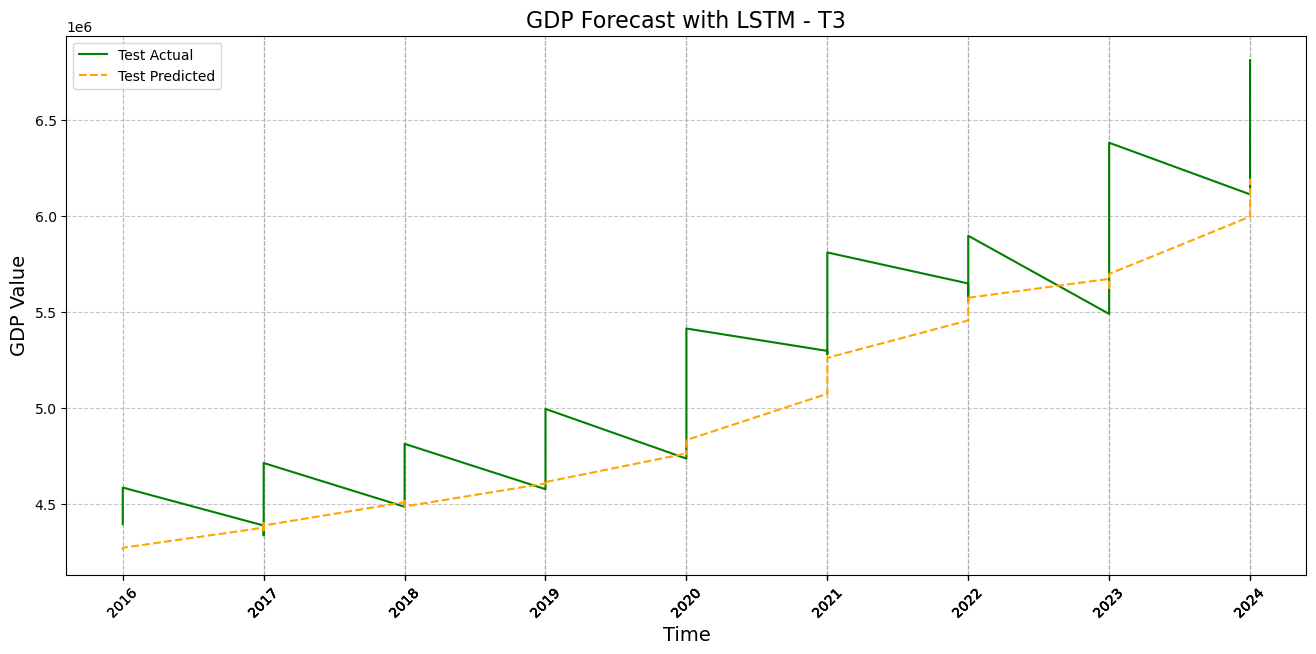

In [18]:
plot_gdp_forecast(year_df,'LSTM - T3',y_true_lstm_test,y_pred_lstm_test)

In [21]:
model.save(os.path.join(base_path,os.getenv("SIN_G_LSTM_T3")))